# Find bills from a keyword search

In [1]:
import datetime as dt
import json
import os
import re
from pathlib import Path
from urllib import parse

import numpy as np
import pandas as pd
import requests
from IPython.display import Image
from legcop import LegiScan

In [2]:
legis = LegiScan(apikey=os.getenv('LEGISCAN_API_KEY'))

## Composing your query

The most important aspect of using the search function of the API is knowing how it expects those searches to be structured. LegiScan documents the syntax on its Full Text Search [help page](https://legiscan.com/fulltext-search).

LegiScan also maintains a table of the most popular recent simple and complex searches [here](https://legiscan.com/trends/search).

We can easily grab that table with pandas' `read_html`:

In [3]:
top_searches = pd.read_html('https://legiscan.com/trends/search', extract_links='body')[
    0
]

In [4]:
top_searches.head()

,Rank,Simple Searches,Rank.1,Complex Searches
0,"(1, None)","(insurance, /gaits/search?keyword=insurance)","(1, None)","(""e-liquid"" OR ""non-tobacco"" OR ""electronic ci..."
1,"(2, None)","(workers' compensation, /gaits/search?keyword=...","(2, None)","(presumption AND presumed, /gaits/search?keywo..."
2,"(3, None)","(abortion, /gaits/search?keyword=abortion)","(3, None)",(hemp OR cannabis OR marijuana OR cannabidiol ...
3,"(4, None)","(animal, /gaits/search?keyword=animal)","(4, None)","(""Biological sex"" OR ""puberty"" OR ""hormone"" OR..."
4,"(5, None)","(education, /gaits/search?keyword=education)","(5, None)","(fish AND commission, /gaits/search?keyword=fi..."


### Query forensics

This is what a person would enter in the full text interface.

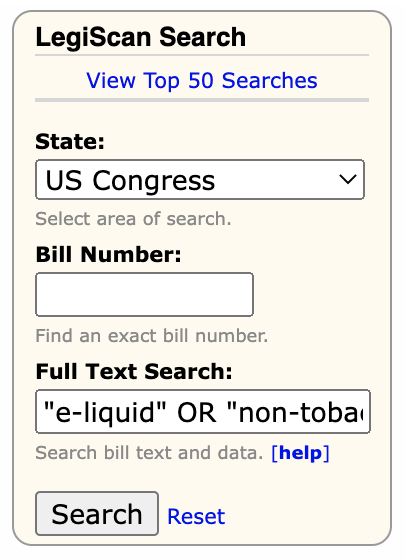

In [5]:
Image(filename='../01_inputs/documentation/full_text.png', retina=True)

In [6]:
query_text = top_searches.at[0, 'Complex Searches'][0]
query_text

'"e-liquid" OR "non-tobacco" OR "electronic cigarette" OR Vapor OR vaping'

In [7]:
url = top_searches.at[0, 'Complex Searches'][1]
query = parse.urlparse(url).query
query

'keyword=%22e-liquid%22+OR+%22non-tobacco%22+OR+%22electronic+cigarette%22+OR+Vapor+OR+vaping'

In [8]:
working_query_string = query.split('=')[1]

In [9]:
my_query_string = parse.quote_plus(query_text)

In [10]:
assert my_query_string == working_query_string

In [11]:
query_text.split()[0]

'"e-liquid"'

In [13]:
def test_encoding(query):
    query_string = parse.urlencode({'keyword': query}, quote_via=parse.quote_plus)
    url = parse.urlunsplit(
        (
            'https',
            'legiscan.com',
            '/gaits/search',
            query_string,
            '',
        )
    )
    print(url)

In [14]:
test_encoding(my_query_string)

https://legiscan.com/gaits/search?keyword=%2522e-liquid%2522%2BOR%2B%2522non-tobacco%2522%2BOR%2B%2522electronic%2Bcigarette%2522%2BOR%2BVapor%2BOR%2Bvaping


In [15]:
search = legis.search(state='All', query=my_query_string, year=2, page=1)

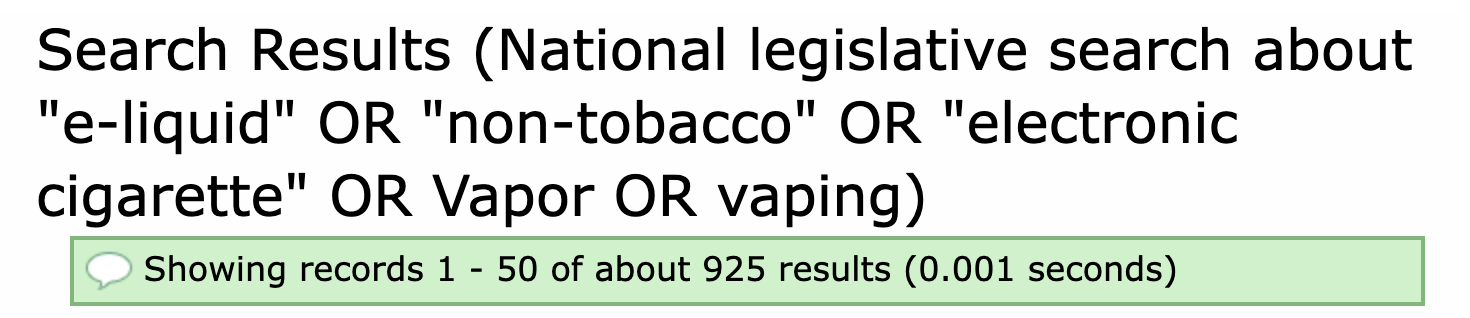

In [16]:
Image(filename='../01_inputs/documentation/query_result.png', retina=True)

## 🚩

In [18]:
search['summary']['count']

944

## Retrieving query results

### Capturing metadata

In [19]:
def synthesize_path_name(query):
    """Helper function for update_and_export_search_result()"""
    timestamp = dt.datetime.now().strftime('%y%m%d-%H%M%S')
    if truncated_query := re.search(r'[a-zA-Z]+\-*[a-zA-Z]+', query):
        return f'{truncated_query.group(0)}_{timestamp}'

You can test the helper function I've written here to see if it's actually all that helpful for generating filenames!

In [20]:
synthesize_path_name(my_query_string)

'e-liquid_221214-105001'

In [21]:
def capture_query_metadata(state, query_str, year, page, relevance_threshold):
    """Helper function for conduct_keyword_search()"""
    return {
        'arguments': {
            'state': state,
            'query': parse.unquote_plus(query_str),
            'year': year,
            'page': page,
            'relevance_threshold': relevance_threshold,
        },
        'date': dt.datetime.now().strftime('%y-%m-%d'),
    }

In [22]:
def update_and_export(path_name, metadata, search_result_obj):
    """Helper function for save_paginated_results(). Saves object returned
    by legis.get_search() to a json file, with additional metadata regarding
    the search parameters.

    Parameters
    ----------
    path_name : str, optional
    metadata : dict
        Generated by capture_query_metadata().
            metadata['date'] is an ISO-formatted representation of
            the date the search was run.
            metadata['arguments'] comprises key-value pairs describing
            arguments passed to legis.get_search()

    search_result_obj : dict
        Object returned by legis.get_search()

    Returns
    -------
    None
    """
    if path_name is None:
        path_name = synthesize_path_name(metadata['arguments']['query'])
    Path(f'../04_outputs/search/{path_name}').mkdir(parents=True, exist_ok=True)
    search_result_obj['query_metadata'] = metadata
    page = metadata['arguments']['page']
    with open(f'../04_outputs/search/{path_name}/p{page}.json', 'w') as fp:
        json.dump(search_result_obj, fp)

### Previewing results

In [23]:
def conduct_keyword_search(
    query,
    path_name=None,
    state='All',
    year=2,
    page=1,
    relevance_threshold=0,
    preview=True,
):
    """Runs legis.get_search() and captures query metadata, optionally saving
    paginated results.

    Parameters
    ----------
    query : str
    path_name : str, optional
    state : str, optional
        Must be 'All' or a valid ANSI code. See TK.
    year : int, default 2
    page : int, default 1
    relevance_threshold : int, default 0
    preview : bool, default True
    """
    query_str = parse.quote_plus(query)
    first_page_obj = legis.search(state=state, query=query_str, year=year, page=page)

    if preview:
        print(first_page_obj['summary'])
        return first_page_obj['results'][0:5]
    else:
        metadata = capture_query_metadata(
            state, query_str, year, page, relevance_threshold
        )
        if first_page_obj['summary']['page_total'] == 1:
            update_and_export(path_name, metadata, first_page_obj)
        else:
            save_paginated_results(query_str, path_name, metadata, first_page_obj)

### Handling pagination

In [24]:
def save_paginated_results(query_str, path_name, metadata, first_page_obj):
    """Optional function called by conduct_keyword_search() to handle
    paginated results

    Parameters
    ----------

    metadata : dict
        Metadata regarding search parameters.

    first_page_obj : dict
        The first page of results returned by legis.get_search(), typically 1.

    Returns
    -------

    See Also
    --------

    conduct_keyword_search
    update_and_export

    None
    """
    min_relevance = first_page_obj['results'][-1]['relevance']
    relevance_threshold = metadata['arguments']['relevance_threshold']
    total = first_page_obj['summary']['page_total']
    update_and_export(path_name, metadata, first_page_obj)
    current_page = int(first_page_obj['summary']['page_current']) + 1
    args = metadata['arguments']
    
    if path_name is None:
        path_name = synthesize_path_name(args['query'])
    
    try:
        while min_relevance >= relevance_threshold and current_page < total:
            search_result_obj = legis.search(
                state=args['state'], query=query_str, page=current_page
            )
            min_relevance = search_result_obj['results'][-1]['relevance']
            metadata['arguments'].update({'page': current_page})
            update_and_export(path_name, metadata, search_result_obj)
            current_page += 1
    except Exception as e:
        print(f'Error: {str(e)}.')
    finally:
        print(
            f'{current_page} out of {total} pages saved to ../04_outputs/search/{path_name}/.'
        )

In [25]:
example_query_string = ''

In [26]:
conduct_keyword_search(example_query_string, year=1, relevance_threshold=90, preview=False)